<a href="https://colab.research.google.com/github/garynico/IndoBERT-Hoax/blob/main/IndoBERT_Hoax_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IndoBERT for Bahasa Indonesia Hoax News Detection

### Import library

In [1]:
# Drive
from google.colab import files
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
source_folder = '/content/drive/MyDrive/TASI/GridSearch/DataImbalance'
destination_folder = '/content/drive/MyDrive/TASI/GridSearch/ModelImbalance4'

In [3]:
%cd //content/drive/MyDrive/TASI/GridSearch/DataImbalance

/content/drive/MyDrive/TASI/GridSearch/DataImbalance


In [4]:
!pip install transformers
!pip install keras.preprocessing
!pip install git+https://github.com/pytorch/text.git@v0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.30.2-py3-none-any.whl (7.2 MB)
  Using cached huggingface_hub-0.15.1-py3-none-any.whl (236 kB)
  Using cached tokenizers-0.13.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.8 MB)
  Using cached safetensors-0.3.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pytorch/text.git (to revision v0.10.0) to /tmp/pip-req-build-7ngp_vzg
  Running command git clone --filter=blob:none --quiet https://github.com/pytorch/text.git /tmp/pip-req-build-7ngp_vzg
  Running command git checkout -q 4da1de36247aa06622088e78508e0e38a4392e38
  Resolved https://github.com/pytorch/text.git to commit 4da1de36247aa06622088e7850

In [5]:
import pandas as pd
import numpy as np
import torch


from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Preliminaries
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator


# Models
import torch.nn as nn

# Training
import torch.optim as optim

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

## Preliminaries

In [6]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
import random

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # jika menggunakan multiple GPUs
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Model

In [9]:
# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('Label', label_field), ('Tokenizing_Head', text_field), ('Tokenizing_Body', text_field)]

train, valid, test = TabularDataset.splits(path=source_folder, train='train3.csv', validation='valid3.csv', test='test3.csv',
                                           format='csv', fields=fields, skip_header=True)


In [10]:
# Iterators
train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.Tokenizing_Body),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.Tokenizing_Body),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

In [11]:
# Module
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "indobenchmark/indobert-base-p1"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    # def forward(self, headline, body, label=None):
    #     loss, text_fea = self.encoder(input_ids=body, attention_mask=(body!=PAD_INDEX), token_type_ids=(headline!=PAD_INDEX), labels=label)[:2]
    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [12]:
def save_checkpoint(save_path, model, valid_loss):
    if save_path is None:
        return

    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}

    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model):
    if load_path is None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, epoch_list):
    if save_path is None:
        return

    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'epoch_list': epoch_list}

    torch.save(state_dict, save_path)
    print(f'Metrics saved to ==> {save_path}')


def load_metrics(load_path):
    if load_path is None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Metrics loaded from <== {load_path}')

    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['epoch_list']

## Training and Validation

In [13]:
def train(model,
          optimizer,
          criterion=nn.BCELoss(),
          train_loader=train_iter,
          valid_loader=valid_iter,
          num_epochs=10,
          eval_every=1,
          file_path=destination_folder,
          best_valid_loss=float("Inf"),
          patience=3):

    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    epoch_list = []
    early_stopping_counter = 0

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, title, text), _ in train_loader:
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            text = text.type(torch.LongTensor)
            text = text.to(device)
            output = model(text, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()

        # evaluation step
        if epoch % eval_every == 0:
            model.eval()
            with torch.no_grad():
                # validation loop
                for (labels, title, text), _ in valid_loader:
                    labels = labels.type(torch.LongTensor)
                    labels = labels.to(device)
                    text = text.type(torch.LongTensor)
                    text = text.to(device)
                    output = model(text, labels)
                    loss, _ = output

                    valid_running_loss += loss.item()

            # evaluation
            average_train_loss = running_loss / len(train_loader)
            average_valid_loss = valid_running_loss / len(valid_loader)
            train_loss_list.append(average_train_loss)
            valid_loss_list.append(average_valid_loss)
            epoch_list.append(epoch)

            # resetting running values
            running_loss = 0.0
            valid_running_loss = 0.0
            model.train()

            # print progress
            print('Epoch [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                  .format(epoch+1, num_epochs, average_train_loss, average_valid_loss))

            # checkpoint
            if best_valid_loss > average_valid_loss:
                best_valid_loss = average_valid_loss
                save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, epoch_list)
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
                if early_stopping_counter >= patience:
                    print("Early stopping")
                    break

    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, epoch_list)
    print('Finished Training!')
    return train_loss_list, valid_loss_list, epoch_list, best_valid_loss

In [14]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train_loss_list, valid_loss_list, epoch_list, best_valid_loss = train(model=model, optimizer=optimizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6521, Valid Loss: 0.7228
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/10], Train Loss: 0.6210, Valid Loss: 0.6529
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/10], Train Loss: 0.2738, Valid Loss: 0.2941
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [4/10], Train Loss: 0.1369, Valid Loss: 0.2067
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [5/10], Train Loss: 0.0909, Valid Loss: 0.1357
Model saved to ==> /content/drive/MyDrive/TASI/GridSear

Metrics loaded from <== /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt


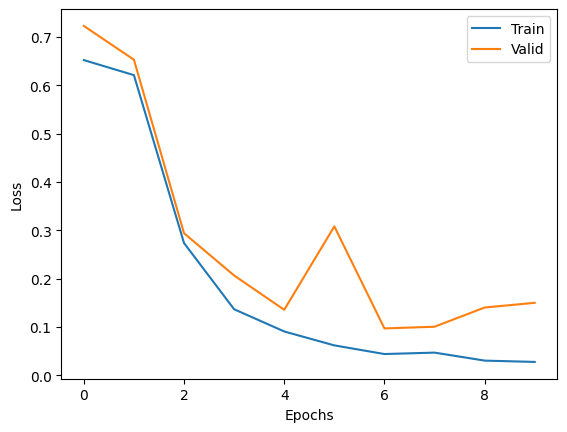

In [15]:
train_loss_list, valid_loss_list, epoch_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(epoch_list, train_loss_list, label='Train')
plt.plot(epoch_list, valid_loss_list, label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from <== /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Classification Report:
Real - Precision: 0.9633, Recall: 0.9292, F1-Score: 0.9459
Fake - Precision: 0.8632, Recall: 0.9266, F1-Score: 0.8938
Accuracy: 0.9283582089552239


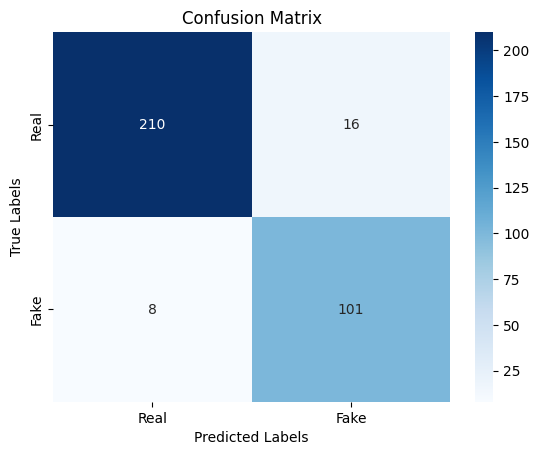

In [16]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, title, text), _ in test_loader:
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            text = text.type(torch.LongTensor)
            text = text.to(device)
            output = model(text, labels)

            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())

    # Mengganti label 1 menjadi "fake" dan label 0 menjadi "real"
    y_true = np.where(np.array(y_true) == 0, "real", "fake")
    y_pred = np.where(np.array(y_pred) == 0, "real", "fake")

    # Menghitung dan mencetak hasil precision, recall, f1-score, dan accuracy
    report = classification_report(y_true, y_pred, labels=["real", "fake"], digits=4, output_dict=True)
    print('Classification Report:')
    for label, scores in report.items():
        if label in ["real", "fake"]:
            precision = scores['precision']
            recall = scores['recall']
            f1_score = scores['f1-score']
            print(f"{label.capitalize()} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy}')

    # Menghitung dan mencetak confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt="d")
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['Real', 'Fake'])
    ax.yaxis.set_ticklabels(['Real', 'Fake'])
    plt.show()

best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)

##Hyperparameter Tuning with Import Grid

In [17]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.9 MB/s eta 0:00:00


In [19]:
import optuna

# Define an objective function to optimize hyperparameters
def objective(trial):
    # Sample hyperparameters
    lr = trial.suggest_categorical('lr', [2e-5, 3e-5, 5e-5])
    num_epochs = trial.suggest_categorical('num_epochs', [5, 6, 7, 8, 9, 10])
    batch_size = trial.suggest_categorical('batch_size', [16, 32])

    # Define model, optimizer, and criterion
    model = BERT().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    # Train model
    train_loss_list, valid_loss_list, epoch_list, best_valid_loss = train(model=model,
                                                                          optimizer=optimizer,
                                                                          criterion=criterion,
                                                                          train_loader=train_iter,
                                                                          valid_loader=valid_iter,
                                                                          num_epochs=num_epochs,
                                                                          eval_every=1,
                                                                          file_path=destination_folder)

    # Save results
    key = f'lr={lr}, num_epochs={num_epochs}, batch_size={batch_size}'
    results[key] = {
        'train_loss': train_loss_list[-1],
        'valid_loss': valid_loss_list,
        'epoch_list': epoch_list,
        'best_valid_loss': best_valid_loss,
        'lr': lr,
        'num_epochs': num_epochs,
        'batch_size': batch_size,
    }

    # Save model if best
    if best_valid_loss < results.get('best_valid_loss', float('inf')):
        results['best_valid_loss'] = best_valid_loss
        results['best_model'] = key
        torch.save(model.state_dict(), f'{destination_folder}/model_{key}.pt')

    # Implement early stopping
    if len(valid_loss_list) >= 3:
        if best_valid_loss > results['best_valid_loss']:
            print("Validation loss hasn't improved in the last 3 epochs. Stopping early.")
            raise optuna.TrialPruned()

    return best_valid_loss

# Set up Optuna study with GridSampler
sampler = optuna.samplers.GridSampler({
    'lr': [2e-5, 3e-5, 5e-5],
    'num_epochs': [5, 6, 7, 8, 9, 10],
    'batch_size': [16, 32]
})
study = optuna.create_study(direction='minimize', sampler=sampler)

# Run optimization
results = {}
study.optimize(objective)

# Print best model and hyperparameters
best_model = results['best_model']
best_hyperparams = results[best_model]
print('Best model:', best_model)
print('Best valid loss:', best_hyperparams['best_valid_loss'])

[I 2023-06-21 07:47:17,616] A new study created in memory with name: no-name-a96570ff-6c4c-4687-ad75-91095ea587c2
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/6], Train Loss: 0.6265, Valid Loss: 0.7093
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/6], Train Loss: 0.3259, Valid Loss: 0.2731
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/6], Train Loss: 0.2481, Valid Loss: 0.2492
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [4/6], Train Loss: 0.1320, Valid Loss: 0.1195
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [5/6], Train Loss: 0.0558, Valid Loss: 0.1442
Epoch [6/6], Train Loss: 0.0335, Valid Loss: 0.1281
Metrics 

[I 2023-06-21 07:49:23,679] Trial 0 finished with value: 0.11949135097009796 and parameters: {'lr': 2e-05, 'num_epochs': 6, 'batch_size': 16}. Best is trial 0 with value: 0.11949135097009796.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6404, Valid Loss: 0.6670
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/9], Train Loss: 0.5001, Valid Loss: 0.2903
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/9], Train Loss: 0.2231, Valid Loss: 0.1815
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [4/9], Train Loss: 0.1146, Valid Loss: 0.2221
Epoch [5/9], Train Loss: 0.0622, Valid Loss: 0.2462


[I 2023-06-21 07:51:21,309] Trial 1 pruned. 


Epoch [6/9], Train Loss: 0.0663, Valid Loss: 0.2211
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6756, Valid Loss: 0.6481
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/7], Train Loss: 0.6652, Valid Loss: 0.6951
Epoch [3/7], Train Loss: 0.6852, Valid Loss: 0.6640


[I 2023-06-21 07:52:37,898] Trial 2 pruned. 


Epoch [4/7], Train Loss: 0.7161, Valid Loss: 0.7058
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.5374, Valid Loss: 0.3777
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/8], Train Loss: 0.2724, Valid Loss: 0.2039
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/8], Train Loss: 0.1817, Valid Loss: 0.1836
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [4/8], Train Loss: 0.0734, Valid Loss: 0.1897
Epoch [5/8], Train Loss: 0.0339, Valid Loss: 0.2581
Epoch [6/8], Train Loss: 0.0162, Valid Loss: 0.1801
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [7

[I 2023-06-21 07:55:16,146] Trial 3 pruned. 


Epoch [8/8], Train Loss: 0.0173, Valid Loss: 0.1879
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6261, Valid Loss: 0.4721
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/10], Train Loss: 0.3343, Valid Loss: 0.2346
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/10], Train Loss: 0.2181, Valid Loss: 0.1944
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [4/10], Train Loss: 0.1165, Valid Loss: 0.2328
Epoch [5/10], Train Loss: 0.0606, Valid Loss: 0.1409
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [6/10], Train Loss: 0.0437, Valid Loss: 0.1478
Ep

[I 2023-06-21 07:58:29,833] Trial 4 pruned. 


Epoch [10/10], Train Loss: 0.0156, Valid Loss: 0.1759
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6464, Valid Loss: 0.5767
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/10], Train Loss: 0.3636, Valid Loss: 0.4724
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/10], Train Loss: 0.2054, Valid Loss: 0.8379
Epoch [4/10], Train Loss: 0.1325, Valid Loss: 0.3792
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [5/10], Train Loss: 0.0979, Valid Loss: 0.3333
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Model saved to ==> /content/drive/MyDrive/TASI/GridSear

[I 2023-06-21 08:01:52,478] Trial 5 pruned. 


Epoch [10/10], Train Loss: 0.0011, Valid Loss: 0.3331
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6159, Valid Loss: 0.4309
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/9], Train Loss: 0.2910, Valid Loss: 0.3485
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/9], Train Loss: 0.1861, Valid Loss: 0.2272
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [4/9], Train Loss: 0.1099, Valid Loss: 0.2019
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [5/9], Train Loss: 0.0778, Valid Loss: 0.2878
Epoch [6/9], Train Loss: 0.0914, Valid Loss: 0.2961
Epoch [7

[I 2023-06-21 08:04:50,996] Trial 6 pruned. 


Epoch [9/9], Train Loss: 0.0338, Valid Loss: 0.3389
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6634, Valid Loss: 0.6431
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/10], Train Loss: 0.6439, Valid Loss: 0.6479
Epoch [3/10], Train Loss: 0.3482, Valid Loss: 0.4018
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [4/10], Train Loss: 0.2222, Valid Loss: 0.2044
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [5/10], Train Loss: 0.1149, Valid Loss: 0.2379
Epoch [6/10], Train Loss: 0.0559, Valid Loss: 0.3470
Epoch [7/10], Train Loss: 0.0451, Valid Loss: 0.1906
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/

[I 2023-06-21 08:08:10,699] Trial 7 pruned. 


Epoch [10/10], Train Loss: 0.0208, Valid Loss: 0.5813
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6804, Valid Loss: 0.7224
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/7], Train Loss: 0.6816, Valid Loss: 0.6750
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/7], Train Loss: 0.6833, Valid Loss: 0.6686
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [4/7], Train Loss: 0.6351, Valid Loss: 0.4489
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [5/7], Train Loss: 0.2852, Valid Loss: 0.4081
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/Mo

[I 2023-06-21 08:10:33,055] Trial 8 pruned. 


Epoch [7/7], Train Loss: 0.1012, Valid Loss: 0.2932
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6497, Valid Loss: 0.6434
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/8], Train Loss: 0.4437, Valid Loss: 0.2816
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/8], Train Loss: 0.2115, Valid Loss: 0.1774
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [4/8], Train Loss: 0.1034, Valid Loss: 0.1843
Epoch [5/8], Train Loss: 0.0490, Valid Loss: 0.2246
Epoch [6/8], Train Loss: 0.0734, Valid Loss: 0.1409
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [7

[I 2023-06-21 08:13:08,474] Trial 9 pruned. 


Epoch [8/8], Train Loss: 0.0047, Valid Loss: 0.1732
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6421, Valid Loss: 0.6949
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/9], Train Loss: 0.6066, Valid Loss: 0.8869
Epoch [3/9], Train Loss: 0.4766, Valid Loss: 0.4355
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [4/9], Train Loss: 0.1866, Valid Loss: 0.3090
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [5/9], Train Loss: 0.0678, Valid Loss: 0.3459
Epoch [6/9], Train Loss: 0.0334, Valid Loss: 0.4550


[I 2023-06-21 08:15:23,988] Trial 10 pruned. 


Epoch [7/9], Train Loss: 0.0556, Valid Loss: 0.3209
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/6], Train Loss: 0.6651, Valid Loss: 0.7269
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/6], Train Loss: 0.7041, Valid Loss: 0.6783
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/6], Train Loss: 0.6995, Valid Loss: 0.6659
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [4/6], Train Loss: 0.6923, Valid Loss: 0.6916
Epoch [5/6], Train Loss: 0.6670, Valid Loss: 0.6589
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [6/6], Train Loss: 0.7246, Valid Loss: 0.6569


[I 2023-06-21 08:17:25,871] Trial 11 pruned. 


Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6940, Valid Loss: 0.6476
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/10], Train Loss: 0.5149, Valid Loss: 0.3974
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/10], Train Loss: 0.2982, Valid Loss: 0.3074
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [4/10], Train Loss: 0.1738, Valid Loss: 0.2790
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [5/10], Train Loss: 0.0920, Valid Loss: 0.2630
Model saved to ==> /content/drive/MyDrive/TASI/GridSear

[I 2023-06-21 08:20:47,740] Trial 12 pruned. 


Epoch [10/10], Train Loss: 0.0074, Valid Loss: 0.2533
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6701, Valid Loss: 0.7097
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/9], Train Loss: 0.6759, Valid Loss: 0.5469
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/9], Train Loss: 0.6172, Valid Loss: 0.7206
Epoch [4/9], Train Loss: 0.6930, Valid Loss: 0.6630


[I 2023-06-21 08:22:24,218] Trial 13 pruned. 


Epoch [5/9], Train Loss: 0.7008, Valid Loss: 0.6717
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6793, Valid Loss: 0.6594
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/10], Train Loss: 0.6868, Valid Loss: 0.6383
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/10], Train Loss: 0.4248, Valid Loss: 0.7026
Epoch [4/10], Train Loss: 0.2200, Valid Loss: 0.3834
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [5/10], Train Loss: 0.1476, Valid Loss: 0.3065
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [6/10], Train Loss: 0.0841, Valid Loss: 0.3224
Ep

[I 2023-06-21 08:24:59,763] Trial 14 pruned. 


Epoch [8/10], Train Loss: 0.0413, Valid Loss: 0.5520
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6399, Valid Loss: 0.6339
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/7], Train Loss: 0.3927, Valid Loss: 0.3349
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/7], Train Loss: 0.2122, Valid Loss: 0.2881
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [4/7], Train Loss: 0.1709, Valid Loss: 0.2272
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [5/7], Train Loss: 0.1205, Valid Loss: 0.2417
Epoch [6/7], Train Loss: 0.0641, Valid Loss: 0.1528
Model sa

[I 2023-06-21 08:27:22,089] Trial 15 pruned. 


Epoch [7/7], Train Loss: 0.0390, Valid Loss: 0.2075
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.6606, Valid Loss: 0.6365
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/5], Train Loss: 0.7005, Valid Loss: 0.6889
Epoch [3/5], Train Loss: 0.4949, Valid Loss: 0.3035
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [4/5], Train Loss: 0.2137, Valid Loss: 0.1735
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt


[I 2023-06-21 08:29:02,128] Trial 16 pruned. 


Epoch [5/5], Train Loss: 0.0850, Valid Loss: 0.2369
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6256, Valid Loss: 0.4040
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/8], Train Loss: 0.3288, Valid Loss: 0.2110
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/8], Train Loss: 0.2118, Valid Loss: 0.1973
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [4/8], Train Loss: 0.1482, Valid Loss: 0.2382
Epoch [5/8], Train Loss: 0.0904, Valid Loss: 0.1902
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [6/8], Train Loss: 0.0612, Valid Loss: 0.1901
Model sa

[I 2023-06-21 08:31:46,968] Trial 17 finished with value: 0.10687316997375872 and parameters: {'lr': 5e-05, 'num_epochs': 8, 'batch_size': 32}. Best is trial 17 with value: 0.10687316997375872.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/6], Train Loss: 0.6071, Valid Loss: 0.4219
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/6], Train Loss: 0.2968, Valid Loss: 0.2430
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/6], Train Loss: 0.1569, Valid Loss: 0.2673
Epoch [4/6], Train Loss: 0.1232, Valid Loss: 0.2566
Epoch [5/6], Train Loss: 0.0736, Valid Loss: 0.1931
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt


[I 2023-06-21 08:33:44,667] Trial 18 pruned. 


Epoch [6/6], Train Loss: 0.0661, Valid Loss: 0.7017
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.6597, Valid Loss: 0.6522
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/5], Train Loss: 0.6997, Valid Loss: 0.5998
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/5], Train Loss: 0.4008, Valid Loss: 0.6856
Epoch [4/5], Train Loss: 0.3474, Valid Loss: 0.3184
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt


[I 2023-06-21 08:35:23,043] Trial 19 pruned. 


Epoch [5/5], Train Loss: 0.1745, Valid Loss: 0.3756
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6538, Valid Loss: 0.6752
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/9], Train Loss: 0.6872, Valid Loss: 0.5906
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/9], Train Loss: 0.3495, Valid Loss: 0.3363
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [4/9], Train Loss: 0.2024, Valid Loss: 0.2394
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [5/9], Train Loss: 0.1034, Valid Loss: 0.2123
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/Mo

[I 2023-06-21 08:38:22,763] Trial 20 pruned. 


Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6726, Valid Loss: 0.6612
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/7], Train Loss: 0.6931, Valid Loss: 0.7093
Epoch [3/7], Train Loss: 0.6753, Valid Loss: 0.7385
Epoch [4/7], Train Loss: 0.6971, Valid Loss: 0.6577
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [5/7], Train Loss: 0.7081, Valid Loss: 0.6739
Epoch [6/7], Train Loss: 0.7171, Valid Loss: 0.7033


[I 2023-06-21 08:40:38,654] Trial 21 pruned. 


Epoch [7/7], Train Loss: 0.7713, Valid Loss: 0.6597
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6670, Valid Loss: 0.7040
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/8], Train Loss: 0.7145, Valid Loss: 0.6565
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/8], Train Loss: 0.6594, Valid Loss: 0.7103
Epoch [4/8], Train Loss: 0.6576, Valid Loss: 0.6992


[I 2023-06-21 08:42:15,427] Trial 22 pruned. 


Epoch [5/8], Train Loss: 0.4346, Valid Loss: 0.6733
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/6], Train Loss: 0.6428, Valid Loss: 0.5079
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/6], Train Loss: 0.3686, Valid Loss: 0.3894
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/6], Train Loss: 0.3354, Valid Loss: 0.2755
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [4/6], Train Loss: 0.1584, Valid Loss: 0.2409
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [5/6], Train Loss: 0.0936, Valid Loss: 0.2769
Epoch [6/6], Train Loss: 0.0522, Valid Loss: 0.1272


[I 2023-06-21 08:44:16,724] Trial 23 pruned. 


Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.6173, Valid Loss: 0.4877
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/5], Train Loss: 0.3145, Valid Loss: 0.2822
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/5], Train Loss: 0.1347, Valid Loss: 0.2944
Epoch [4/5], Train Loss: 0.1088, Valid Loss: 0.2840


[I 2023-06-21 08:45:54,320] Trial 24 pruned. 


Epoch [5/5], Train Loss: 0.0876, Valid Loss: 0.3456
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6478, Valid Loss: 0.6841
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/8], Train Loss: 0.6741, Valid Loss: 0.6560
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/8], Train Loss: 0.6900, Valid Loss: 0.6748
Epoch [4/8], Train Loss: 0.5619, Valid Loss: 0.3724
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [5/8], Train Loss: 0.2434, Valid Loss: 0.3587
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [6/8], Train Loss: 0.2483, Valid Loss: 0.3569
Model sa

[I 2023-06-21 08:48:33,377] Trial 25 pruned. 


Epoch [8/8], Train Loss: 0.2680, Valid Loss: 0.6475
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.6459, Valid Loss: 0.6240
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/5], Train Loss: 0.3887, Valid Loss: 0.3605
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/5], Train Loss: 0.1967, Valid Loss: 0.2539
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [4/5], Train Loss: 0.1336, Valid Loss: 0.2011
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt


[I 2023-06-21 08:50:13,977] Trial 26 pruned. 


Epoch [5/5], Train Loss: 0.1049, Valid Loss: 0.2429
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/6], Train Loss: 0.6572, Valid Loss: 0.6812
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/6], Train Loss: 0.5063, Valid Loss: 0.3471
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/6], Train Loss: 0.2887, Valid Loss: 0.2351
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [4/6], Train Loss: 0.1855, Valid Loss: 0.2395
Epoch [5/6], Train Loss: 0.1025, Valid Loss: 0.1986
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt


[I 2023-06-21 08:52:12,854] Trial 27 pruned. 


Epoch [6/6], Train Loss: 0.0334, Valid Loss: 0.3980
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6760, Valid Loss: 0.6333
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/9], Train Loss: 0.5169, Valid Loss: 0.5281
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/9], Train Loss: 0.3161, Valid Loss: 0.2598
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [4/9], Train Loss: 0.1638, Valid Loss: 0.2083
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [5/9], Train Loss: 0.0778, Valid Loss: 0.2057
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/Mo

[I 2023-06-21 08:55:10,736] Trial 28 pruned. 


Epoch [9/9], Train Loss: 0.0117, Valid Loss: 0.3185
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/6], Train Loss: 0.6543, Valid Loss: 0.6780
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/6], Train Loss: 0.6753, Valid Loss: 0.7199
Epoch [3/6], Train Loss: 0.6740, Valid Loss: 0.6761
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [4/6], Train Loss: 0.6618, Valid Loss: 0.7365
Epoch [5/6], Train Loss: 0.7314, Valid Loss: 0.6700
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [6/6], Train Loss: 0.6919, Valid Loss: 0.6599
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt


[I 2023-06-21 08:57:09,771] Trial 29 pruned. 


Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6736, Valid Loss: 0.6407
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/8], Train Loss: 0.5654, Valid Loss: 0.4100
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/8], Train Loss: 0.2475, Valid Loss: 0.2180
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [4/8], Train Loss: 0.1761, Valid Loss: 0.1600
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [5/8], Train Loss: 0.0824, Valid Loss: 0.1591
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/Mo

[I 2023-06-21 08:59:47,288] Trial 30 pruned. 


Epoch [8/8], Train Loss: 0.0302, Valid Loss: 0.1609
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.6814, Valid Loss: 0.6950
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/5], Train Loss: 0.5355, Valid Loss: 0.4983
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/5], Train Loss: 0.3060, Valid Loss: 0.2496
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [4/5], Train Loss: 0.1630, Valid Loss: 0.1731
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt


[I 2023-06-21 09:01:30,221] Trial 31 pruned. 


Epoch [5/5], Train Loss: 0.0967, Valid Loss: 0.3021
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6536, Valid Loss: 0.7048
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/7], Train Loss: 0.4752, Valid Loss: 0.2995
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/7], Train Loss: 0.2063, Valid Loss: 0.2474
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [4/7], Train Loss: 0.1538, Valid Loss: 0.4368
Epoch [5/7], Train Loss: 0.1028, Valid Loss: 0.2931


[I 2023-06-21 09:03:31,888] Trial 32 pruned. 


Epoch [6/7], Train Loss: 0.0864, Valid Loss: 0.4235
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6454, Valid Loss: 0.7015
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/10], Train Loss: 0.5807, Valid Loss: 0.3539
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/10], Train Loss: 0.2695, Valid Loss: 0.3490
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [4/10], Train Loss: 0.2060, Valid Loss: 0.5161
Epoch [5/10], Train Loss: 0.2103, Valid Loss: 0.4858


[I 2023-06-21 09:05:30,286] Trial 33 pruned. 


Epoch [6/10], Train Loss: 0.1239, Valid Loss: 1.0803
Early stopping
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.5861, Valid Loss: 0.3922
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/5], Train Loss: 0.3192, Valid Loss: 0.2206
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/5], Train Loss: 0.1989, Valid Loss: 0.1646
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [4/5], Train Loss: 0.1088, Valid Loss: 0.1781


[I 2023-06-21 09:07:08,831] Trial 34 pruned. 


Epoch [5/5], Train Loss: 0.0850, Valid Loss: 0.1992
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6727, Valid Loss: 0.6908
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [2/7], Train Loss: 0.7005, Valid Loss: 0.6622
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [3/7], Train Loss: 0.6319, Valid Loss: 0.4941
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [4/7], Train Loss: 0.3081, Valid Loss: 0.2408
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Epoch [5/7], Train Loss: 0.1676, Valid Loss: 0.2063
Model saved to ==> /content/drive/MyDrive/TASI/GridSearch/Mo

[I 2023-06-21 09:09:28,429] Trial 35 pruned. 


Epoch [7/7], Train Loss: 0.0687, Valid Loss: 0.2096
Metrics saved to ==> /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt
Finished Training!
Validation loss hasn't improved in the last 3 epochs. Stopping early.
Best model: lr=5e-05, num_epochs=8, batch_size=32
Best valid loss: 0.10687316997375872


Metrics loaded from <== /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/metrics.pt


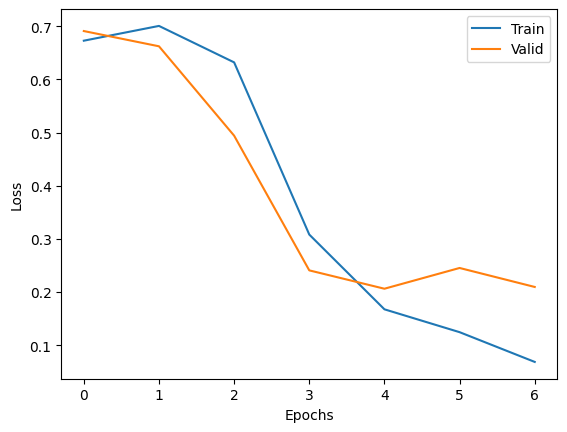

In [20]:
train_loss_list, valid_loss_list, epoch_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(epoch_list, train_loss_list, label='Train')
plt.plot(epoch_list, valid_loss_list, label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from <== /content/drive/MyDrive/TASI/GridSearch/ModelImbalance4/model.pt
Classification Report:
Real - Precision: 0.9462, Recall: 0.9336, F1-Score: 0.9399
Fake - Precision: 0.8661, Recall: 0.8899, F1-Score: 0.8778
Accuracy: 0.9194029850746268


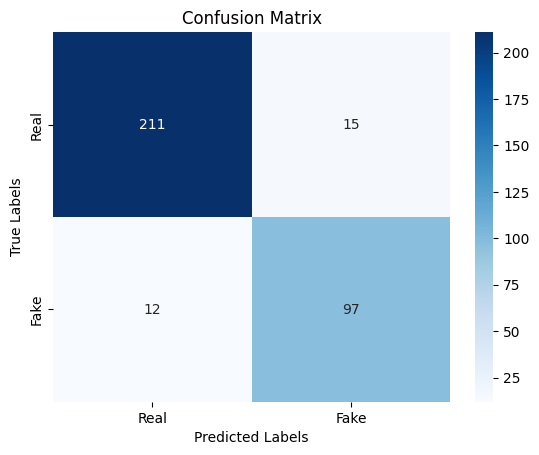

In [21]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, title, text), _ in test_loader:
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            text = text.type(torch.LongTensor)
            text = text.to(device)
            output = model(text, labels)

            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())

    # Mengganti label 1 menjadi "fake" dan label 0 menjadi "real"
    y_true = np.where(np.array(y_true) == 0, "real", "fake")
    y_pred = np.where(np.array(y_pred) == 0, "real", "fake")

    # Menghitung dan mencetak hasil precision, recall, f1-score, dan accuracy
    report = classification_report(y_true, y_pred, labels=["real", "fake"], digits=4, output_dict=True)
    print('Classification Report:')
    for label, scores in report.items():
        if label in ["real", "fake"]:
            precision = scores['precision']
            recall = scores['recall']
            f1_score = scores['f1-score']
            print(f"{label.capitalize()} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy}')

    # Menghitung dan mencetak confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt="d")
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['Real', 'Fake'])
    ax.yaxis.set_ticklabels(['Real', 'Fake'])
    plt.show()

best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)